In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="mathematicsmodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [7]:
mathFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [8]:
mathFOSID = mathFOSID.filter(mathFOSID["Domain"]=="Mathematics").collect()

In [9]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [10]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [11]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [12]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(mathFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [13]:
fos.show(2)

+---------+-----------+
|   FOS_ID|     Domain|
+---------+-----------+
|202444582|Mathematics|
| 42475967|Mathematics|
+---------+-----------+
only showing top 2 rows



In [14]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [15]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [16]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [17]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [18]:
papers_filtered1.count()

3645432

In [19]:
(sample1,sample2) = papers_filtered1.randomSplit([0.3,0.7])

In [20]:
sample1.count()

1093754

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [22]:
papers_filtered1.select(["EstimatedCount"]).show(4)

+--------------+
|EstimatedCount|
+--------------+
|           260|
|             6|
|           387|
|             0|
+--------------+
only showing top 4 rows



In [23]:
sample1_pd = sample1.toPandas()

In [24]:
import numpy as np


In [25]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

## Comparison with Microsoft Predictions

In [26]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 3.8318762719953483)
('Mean Squared Error of EstimatedCount:', 6611.474991634316)
('Root Mean Squared of with EstimatedCount:', 81.31097706727128)


In [27]:
sample1_pd = sample1_pd.drop(["PaperID","EstimatedCount"],axis=1)

In [28]:
sample1_pd.shape

(1093754, 12)

In [29]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

## Random Forest Regression

In [30]:
from sklearn.model_selection import KFold

In [31]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X_train:", len(X_train), "X_test:", len(X_test))
    #print("y_train:", len(y_train), "y_test:", len(y_test))
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 4.39743913717735)
('Mean Squared Error:', 10394.022090514336)
('Root Mean Squared Error:', 101.95107694631939)
('Mean Absolute Error:', 2.389852295669006)
('Mean Squared Error:', 485.5369588251392)
('Root Mean Squared Error:', 22.03490319527497)
('Mean Absolute Error:', 2.388193650621704)
('Mean Squared Error:', 559.5291913733097)
('Root Mean Squared Error:', 23.654369392848114)
('Mean Absolute Error:', 2.2863112774892067)
('Mean Squared Error:', 400.01096994236036)
('Root Mean Squared Error:', 20.000274246678728)
('Mean Absolute Error:', 3.8941229654142706)
('Mean Squared Error:', 9638.03098531368)
('Root Mean Squared Error:', 98.17347393931662)


In [37]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 53.16281954408756)


## XGBoost Regression model

In [38]:
import xgboost as xgb

In [39]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [40]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([ 218751,  218752,  218753, ..., 1093751, 1093752, 1093753]), 'TEST:', array([     0,      1,      2, ..., 218748, 218749, 218750]))
('Mean Absolute Error of XGBoost Kfold:', 4.7388837389748195)
('Mean Squared Error of XGBoost Kfold:', 14975.21511674839)
('Root Mean Squared Error of XGBoost Kfold:', 122.37326144525359)
('TRAIN:', array([      0,       1,       2, ..., 1093751, 1093752, 1093753]), 'TEST:', array([218751, 218752, 218753, ..., 437499, 437500, 437501]))
('Mean Absolute Error of XGBoost Kfold:', 2.5001903936557017)
('Mean Squared Error of XGBoost Kfold:', 478.24285226492395)
('Root Mean Squared Error of XGBoost Kfold:', 21.868764305852398)
('TRAIN:', array([      0,       1,       2, ..., 1093751, 1093752, 1093753]), 'TEST:', array([437502, 437503, 437504, ..., 656250, 656251, 656252]))
('Mean Absolute Error of XGBoost Kfold:', 2.5106947243417466)
('Mean Squared Error of XGBoost Kfold:', 578.3019738862755)
('Root Mean Squared Error of XGBoost Kfold:', 24.04

In [41]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 57.390024108270026)


In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
featureslist=sample1_pd.columns

In [45]:
importances = regressor.feature_importances_

In [47]:
import pandas as pd

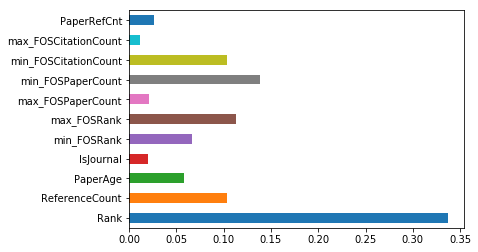

In [48]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [49]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.33698
Feature: 1, Score: 0.10379
Feature: 2, Score: 0.05767
Feature: 3, Score: 0.02027
Feature: 4, Score: 0.06707
Feature: 5, Score: 0.11284
Feature: 6, Score: 0.02152
Feature: 7, Score: 0.13828
Feature: 8, Score: 0.10396
Feature: 9, Score: 0.01142
Feature: 10, Score: 0.02619


In [50]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X_train:", len(X_train), "X_test:", len(X_test))
    #print("y_train:", len(y_train), "y_test:", len(y_test))
    regressor = RandomForestRegressor(n_estimators=200, max_depth=40, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 4.391347132631612)
('Mean Squared Error:', 10750.623890791407)
('Root Mean Squared Error:', 103.68521539154658)
('Mean Absolute Error:', 2.3895481613350884)
('Mean Squared Error:', 507.61140802734536)
('Root Mean Squared Error:', 22.530233199577527)
('Mean Absolute Error:', 2.3855889277244358)
('Mean Squared Error:', 547.2373132657397)
('Root Mean Squared Error:', 23.39310396817275)
('Mean Absolute Error:', 2.2859018257875126)
('Mean Squared Error:', 405.43467704651005)
('Root Mean Squared Error:', 20.13540853934953)
('Mean Absolute Error:', 3.9064949969504905)
('Mean Squared Error:', 9861.140247112835)
('Root Mean Squared Error:', 99.3032741006702)


In [51]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 53.809447039863315)
